In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from features.settings import Baseline_Settings, Triplet_Hinge_Settings, Triplet_Log_Settings, Pair_Hinge_Settings
from features.models import CNNSmall0, CNNSmall1, CNNSmall2, CNNMedium0, CNNMedium1, CNNLarge0, CNNLarge1
from datasets import load_cifar10
import time

/home/dqi/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
def get_feature_model(feature_model, settings, num_features, data_format, f_lr, f_reg, f_scope):
    H, W, C = data_format
    x = tf.placeholder(tf.float32, shape=[None, H, W, C])
    y = tf.placeholder(tf.int64, shape=[None])
    dropout = tf.placeholder(tf.float32)
    f_training = tf.placeholder(tf.bool)
    f_model = feature_model(x=x, y=y, settings=settings, data_format=data_format, num_features=num_features, lr=f_lr, reg=f_reg, dropout=dropout, training=f_training, scope=f_scope)
    return f_model, (x, y, dropout, f_training)

def train_features(sess, feature_model, samplers, num_steps, keep_prob, f_params):  
    
    x, y, dropout, training = f_params
    train, valid, _ = samplers
    
    print("begin training features")
    train_time = time.time()
    for step in range(num_steps):        
        x_, y_ = train.sample(400)
        sess.run(feature_model.optimize, feed_dict={x:x_, y:y_, dropout:keep_prob, training:True})
        train_loss, train_acc = sess.run([feature_model.loss, feature_model.acc], 
                                         feed_dict={x:x_, y:y_, dropout:1.0, training:False})
        x_, y_ = valid.sample(400)
        valid_loss, valid_acc = sess.run([feature_model.loss, feature_model.acc], 
                                            feed_dict={x:x_, y:y_, dropout:1.0, training:False})
        if step % 200 == 0:
            print("\tstep %d: train loss %g, train error %g"
                  %(step, train_loss, 1 - train_acc))
    print("end training features // time elapsed: %.4f s"%(train_time))

    eval_time = time.time()
    x_, y_ = valid.sample(5000)
    valid_error = 1 - sess.run(feature_model.acc, feed_dict={x:x_, y:y_, dropout:1.0, training:False})
    eval_time = time.time() - eval_time
    print("validation set error: %.4f // time elapsed: %.4f s"%(valid_error, eval_time))  

def test_features(sess, feature_model, samplers, f_params):  
    
    x, y, dropout, training = f_params
    _, _, test = samplers
    
    test_time = time.time()
    test_err = 0
    for step in range(1000):
        x_, y_ = test.sample(700)
        test_loss, test_acc = sess.run([feature_model.loss, feature_model.acc], 
                                         feed_dict={x:x_, y:y_, dropout:1.0, training:False})
        test_err += 1 - test_acc
    test_time = time.time() - test_time
    print("test set error: %.4f // time elapsed: %.4f s"%(test_err/1000, test_time))

In [4]:
data, samplers, pair_samplers, triplet_samplers = load_cifar10(augment=True)

CIFAR-10 loaded in 104 seconds


In [5]:
d = data; s = samplers

In [ ]:
tf.reset_default_graph()
f, f_params = get_feature_model(feature_model=CNNSmall0, settings=Baseline_Settings,
                                num_features=10, data_format=[32, 32, 3],
                                f_lr=0.1, f_reg=0.001, f_scope="b_cs0_fmnist_10")
fs = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "b_cs0_fmnist_10"))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_features(sess=sess, feature_model=f, samplers=s, num_steps=5000, keep_prob=1.0, f_params=f_params)
    test_features(sess=sess, feature_model=f, samplers=s, f_params=f_params)

In [10]:
tf.reset_default_graph()
f, f_params = get_feature_model(feature_model=CNNSmall0, settings=Baseline_Settings,
                                num_features=10, data_format=[32, 32, 3],
                                f_lr=0.1, f_reg=0.001, f_scope="b_cs0_fmnist_10")
fs = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "b_cs0_fmnist_10"))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_features(sess=sess, feature_model=f, samplers=s, num_steps=5000, keep_prob=1.0, f_params=f_params)
    test_features(sess=sess, feature_model=f, samplers=s, f_params=f_params)

begin training features
	step 0: train loss 2.47666, train error 0.9075, valid loss 2.46424, valid error 0.885
	step 200: train loss 2.28867, train error 0.75, valid loss 2.24973, valid error 0.7775
	step 400: train loss 1.6392, train error 0.565, valid loss 1.72299, valid error 0.5925
	step 600: train loss 1.38486, train error 0.47, valid loss 1.44241, valid error 0.4775
	step 800: train loss 1.26542, train error 0.4275, valid loss 1.2923, valid error 0.47
	step 1000: train loss 1.25521, train error 0.4475, valid loss 1.40551, valid error 0.4725
	step 1200: train loss 1.18127, train error 0.4075, valid loss 1.23771, valid error 0.42
	step 1400: train loss 1.16122, train error 0.4225, valid loss 1.2777, valid error 0.43
	step 1600: train loss 1.03143, train error 0.3525, valid loss 1.15809, valid error 0.4
	step 1800: train loss 0.983483, train error 0.34, valid loss 1.10021, valid error 0.39
	step 2000: train loss 1.16718, train error 0.365, valid loss 1.25023, valid error 0.415
	step

In [11]:
tf.reset_default_graph()
f, f_params = get_feature_model(feature_model=CNNSmall0, settings=Baseline_Settings,
                                num_features=10, data_format=[32, 32, 3],
                                f_lr=0.1, f_reg=0.001, f_scope="b_cs0_fmnist_10")
fs = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "b_cs0_fmnist_10"))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_features(sess=sess, feature_model=f, samplers=s, num_steps=5000, keep_prob=1.0, f_params=f_params)
    test_features(sess=sess, feature_model=f, samplers=s, f_params=f_params)

begin training features
	step 0: train loss 2.38351, train error 0.905, valid loss 2.42526, valid error 0.9275
	step 200: train loss 1.71083, train error 0.61, valid loss 1.73201, valid error 0.6125
	step 400: train loss 1.84331, train error 0.6225, valid loss 1.86081, valid error 0.6075
	step 600: train loss 1.16654, train error 0.43, valid loss 1.29443, valid error 0.47
	step 800: train loss 1.21624, train error 0.445, valid loss 1.35271, valid error 0.465
	step 1000: train loss 1.18644, train error 0.3975, valid loss 1.2809, valid error 0.435
	step 1200: train loss 1.14315, train error 0.3975, valid loss 1.21392, valid error 0.43
	step 1400: train loss 1.249, train error 0.4525, valid loss 1.28211, valid error 0.4125
	step 1600: train loss 1.00589, train error 0.335, valid loss 1.12978, valid error 0.4025
	step 1800: train loss 1.16954, train error 0.4175, valid loss 1.35615, valid error 0.4275
	step 2000: train loss 0.974302, train error 0.3375, valid loss 1.12544, valid error 0.37

In [13]:
tf.reset_default_graph()
f, f_params = get_feature_model(feature_model=CNNSmall0, settings=Baseline_Settings,
                                num_features=10, data_format=[32, 32, 3],
                                f_lr=0.1, f_reg=0.001, f_scope="b_cs0_fmnist_10")
fs = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "b_cs0_fmnist_10"))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_features(sess=sess, feature_model=f, samplers=s, num_steps=5000, keep_prob=1.0, f_params=f_params)
    test_features(sess=sess, feature_model=f, samplers=s, f_params=f_params)

begin training features
	step 0: train loss 2.41826, train error 0.87
	step 200: train loss 2.11278, train error 0.7
	step 400: train loss 1.43717, train error 0.51
	step 600: train loss 1.4626, train error 0.505
	step 800: train loss 1.17419, train error 0.39
	step 1000: train loss 1.52878, train error 0.5175
	step 1200: train loss 1.51651, train error 0.5075
	step 1400: train loss 1.02164, train error 0.345
	step 1600: train loss 0.891556, train error 0.295
	step 1800: train loss 0.982322, train error 0.3775
	step 2000: train loss 1.09083, train error 0.37
	step 2200: train loss 0.992118, train error 0.3625
	step 2400: train loss 0.892143, train error 0.2875
	step 2600: train loss 0.840717, train error 0.2975
	step 2800: train loss 1.00904, train error 0.3675
	step 3000: train loss 0.788863, train error 0.245
	step 3200: train loss 0.841101, train error 0.2825
	step 3400: train loss 0.788932, train error 0.2825
	step 3600: train loss 0.77227, train error 0.25
	step 3800: train loss 0

In [14]:
tf.reset_default_graph()
f, f_params = get_feature_model(feature_model=CNNSmall0, settings=Baseline_Settings,
                                num_features=10, data_format=[32, 32, 3],
                                f_lr=0.1, f_reg=0.001, f_scope="b_cs0_fmnist_10")
fs = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "b_cs0_fmnist_10"))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_features(sess=sess, feature_model=f, samplers=s, num_steps=5000, keep_prob=1.0, f_params=f_params)
    test_features(sess=sess, feature_model=f, samplers=s, f_params=f_params)

begin training features
	step 0: train loss 2.35496, train error 0.8175
	step 200: train loss 1.70584, train error 0.6075
	step 400: train loss 1.54123, train error 0.55
	step 600: train loss 1.16913, train error 0.395
	step 800: train loss 1.22773, train error 0.4225
	step 1000: train loss 1.10049, train error 0.3625
	step 1200: train loss 1.06484, train error 0.365
	step 1400: train loss 1.10528, train error 0.365
	step 1600: train loss 1.00574, train error 0.335
	step 1800: train loss 1.01762, train error 0.325
	step 2000: train loss 0.885761, train error 0.2875
	step 2200: train loss 0.927674, train error 0.3
	step 2400: train loss 0.919189, train error 0.2825
	step 2600: train loss 0.898849, train error 0.305
	step 2800: train loss 1.21186, train error 0.4275
	step 3000: train loss 0.826678, train error 0.2525
	step 3200: train loss 0.833053, train error 0.2725
	step 3400: train loss 0.943542, train error 0.2975
	step 3600: train loss 0.848891, train error 0.275
	step 3800: train 

In [10]:
import numpy as np
import tensorflow as tf

In [14]:
with tf.Session() as sess:
    a = tf.convert_to_tensor(np.arange(24).reshape((8,3)).astype('float64'))
    print(tf.reduce_sum(tf.square(a), axis=1).eval())
    print(tf.norm(a, axis=1).eval())

[   5.   50.  149.  302.  509.  770. 1085. 1454.]
[ 2.23606798  7.07106781 12.20655562 17.3781472  22.56102835 27.74887385
 32.93933818 38.13135193]


In [12]:
np.arange(24).reshape((8,3))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23]])

In [10]:
from keras.datasets import cifar100
import numpy as np
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [25]:
idx = (y_train.flatten() == 1)

In [26]:
img0 = x_train[idx]

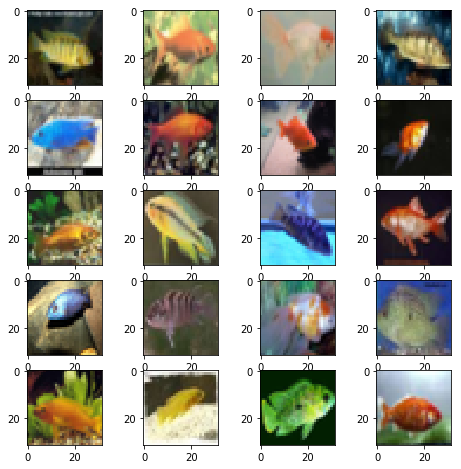

In [27]:
import matplotlib.pyplot as plt
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img0[i])
plt.show()